In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# for downloading the files
import urllib.request
import os
# used versions
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
import sys
print("Python version:", sys.version)
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')  # suppresses default style warning of pd.read_excel()

pandas version: 1.5.3
numpy version: 1.26.4
Python version: 3.11.8 (main, Feb 12 2024, 14:50:05) [GCC 13.2.1 20230801]


# Sterbefälle Deutschland mit bestimmten Todesursachen

Wir verwenden die amtliche Sterbefallstatistik vom [Statistischen Bundesamt](https://www-genesis.destatis.de/genesis/online?sequenz=statistikTabellen&selectionname=23211) (23211-0004: _Gestorbene: Deutschland, Jahre, Todesursachen, Geschlecht, Altersgruppen_).

Dabei haben wir folgende Kategorien ausgewählt:

- Akuter oder rezidivierender Myokardinfarkt
- Grippe
- COVID-19, Virus nachgewiesen
- COVID-19, Virus nicht nachgewiesen
- Plötzlicher Kindstod
- Sonst. ungenau bezeichnete u. unbek. Todesursachen
- Ereignis, dessen nähere Umstände unbestimmt sind
- Insgesamt

Wir lesen nun die altersgruppen- und geschlechtsbezogenen Todesursachenstatistiken vergangener Jahre ein. Diese Zahlen sind Absolutwerte. Wächst in einer Altersgruppe die Populationsgröße, so steigen wahrscheinlich auch die Absolutwerte. Im zweiten Teil dieses Notebooks werden diese Populationseffekte bereinigt (datenbedingt bleiben dann allerdings nur noch vier große Altersgruppen).

In [2]:
# dataframe, männlich
dfm = pd.read_excel("23211-0004-todesursachen.xlsx",
                   sheet_name="23211-0004",
                   skiprows=7,
                   header=0,
                   usecols=range(18),
                   index_col=[0],
                   skipfooter=8
                  )
dfm.replace("^-$", 0, regex=True, inplace=True)
dfm.replace("^\.$", 0, regex=True, inplace=True)
# dataframe, weiblich
dfw = pd.read_excel("23211-0004-todesursachen.xlsx",
                    sheet_name="23211-0004",
                    skiprows=7,
                    header=0,
                    usecols=[0]+list(range(19,19+17)),
                    index_col=[0],
                    skipfooter=8
                  )
# entferne Suffix ".1", durch pandas hinzugefügt wegen Duplikatvermeidung
dfw.columns = dfw.columns.str.replace(".1", "", regex=False)
dfw.replace("^-$", 0, regex=True, inplace=True)
dfw.replace("^\.$", 0, regex=True, inplace=True)

In [3]:
# extrahiere jahresweise die altersgruppenbezogenen Fälle jeweiliger ICDs
#   list_dfm["2016"] beinhaltet dataframe männlicher Sterbefälle entsprechender ICDs für Jahr 2016
list_dfm = []
list_dfw = []
years = np.arange(2016,2023)
count = dfm.index.get_loc(str(years[1])) - dfm.index.get_loc(str(years[0])) - 1
start = 0
end = 0
for year in years:
    start = end + 1
    end = start + count
    list_dfm.append(dfm.iloc[start:end])
    list_dfw.append(dfw.iloc[start:end])

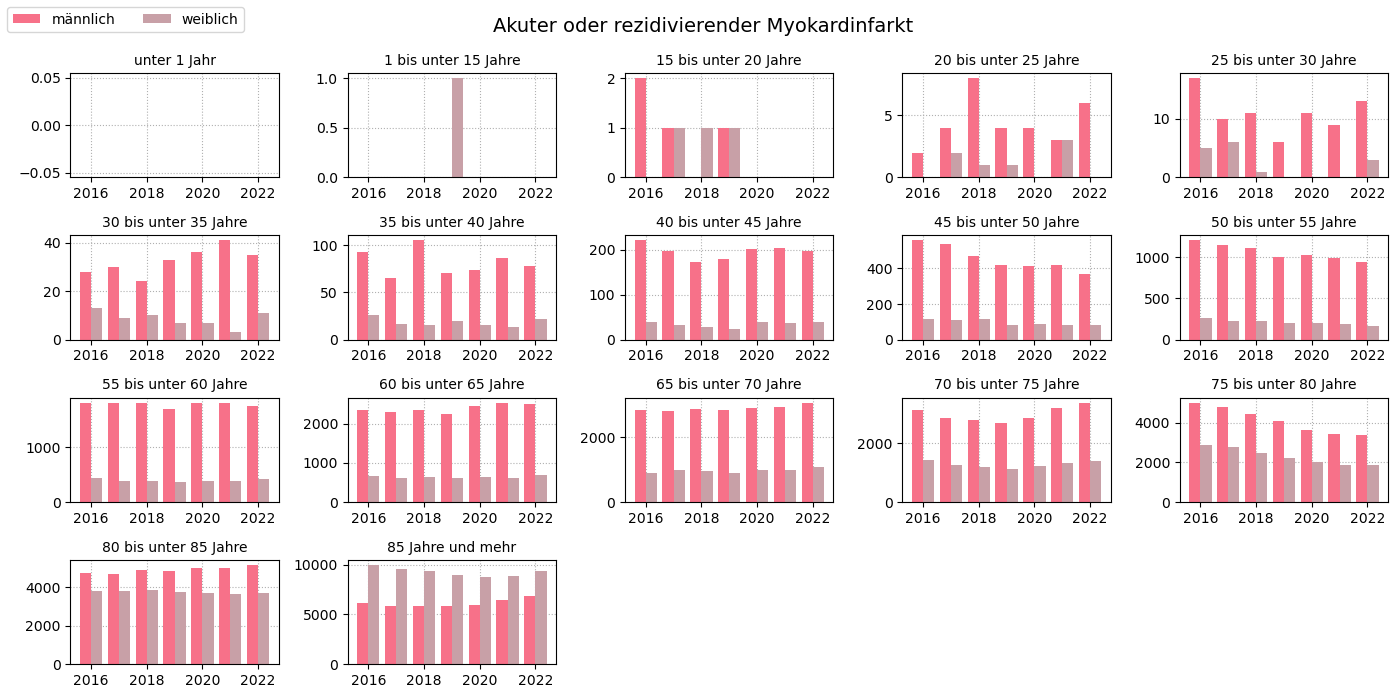

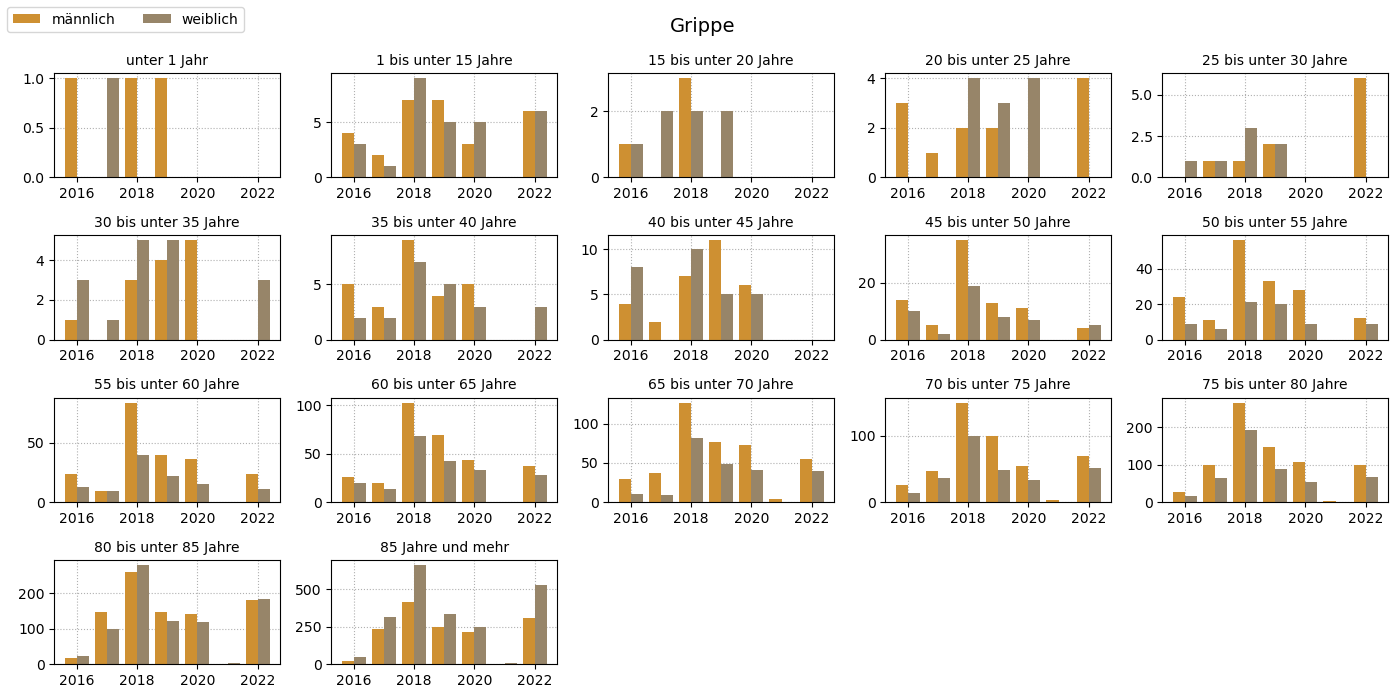

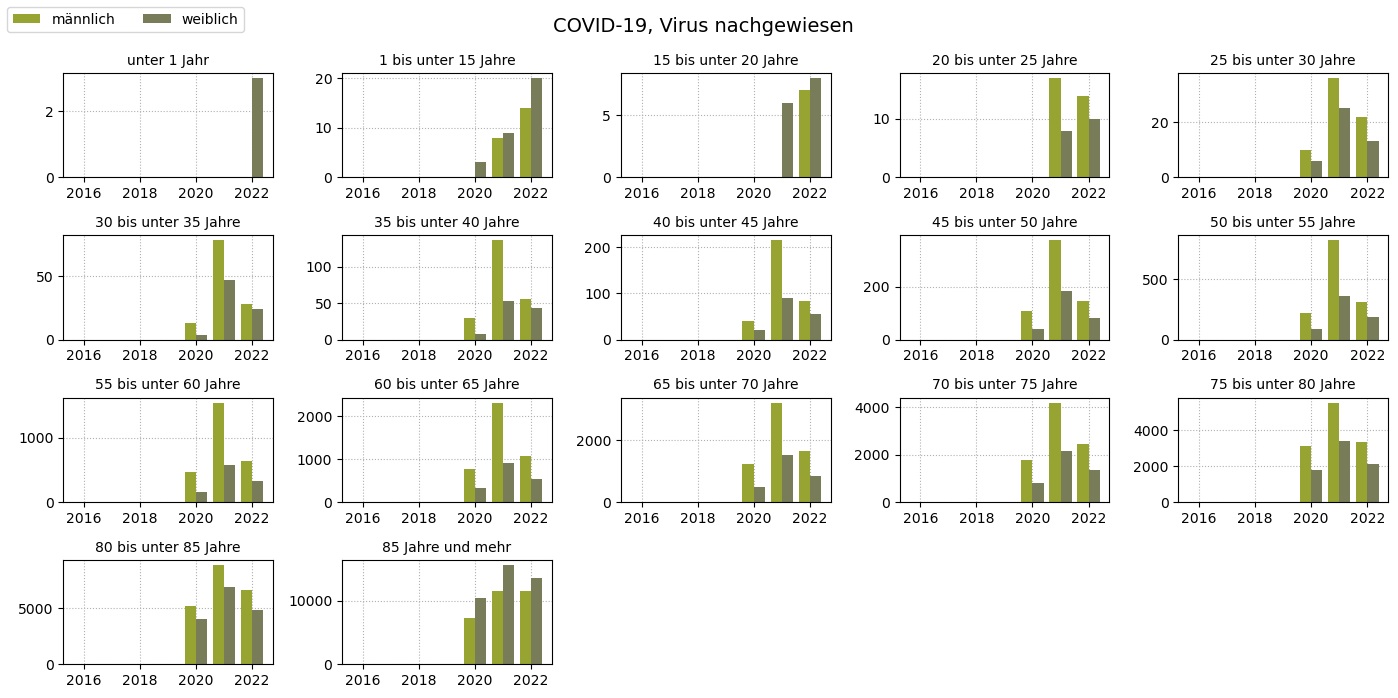

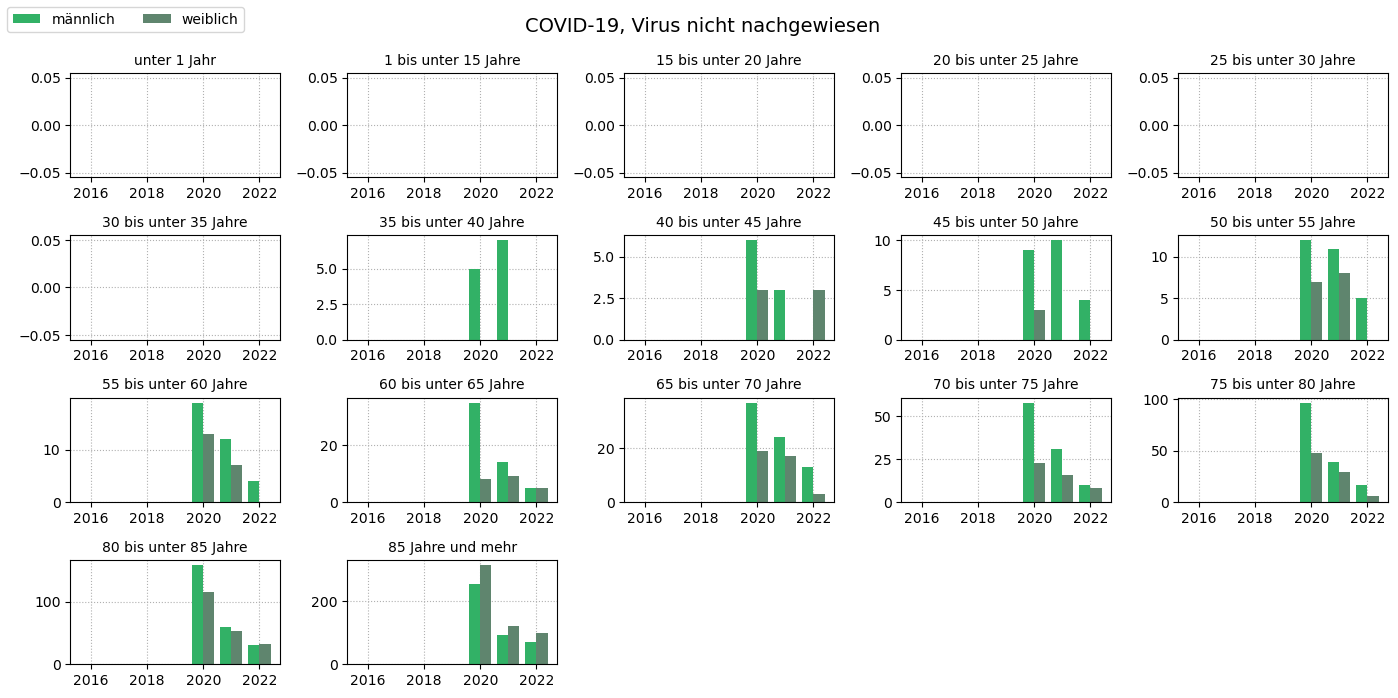

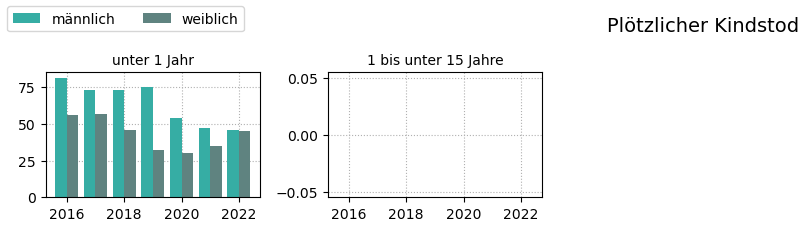

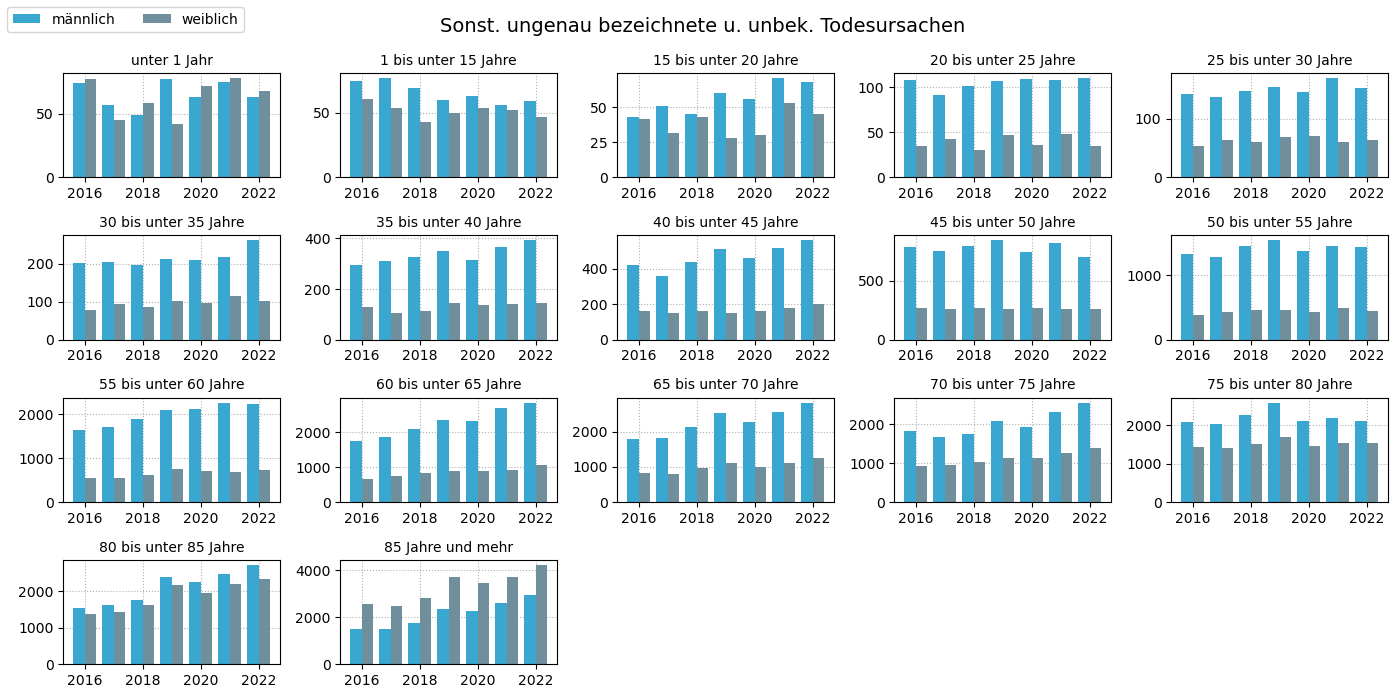

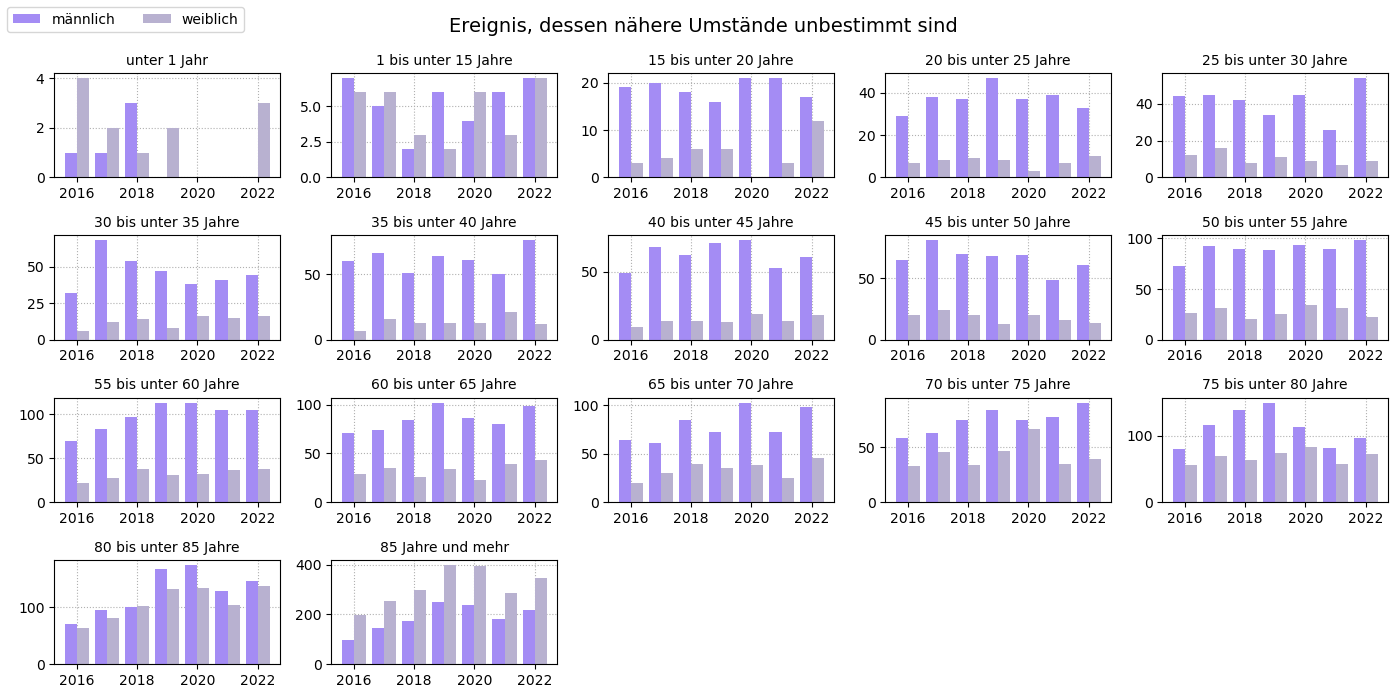

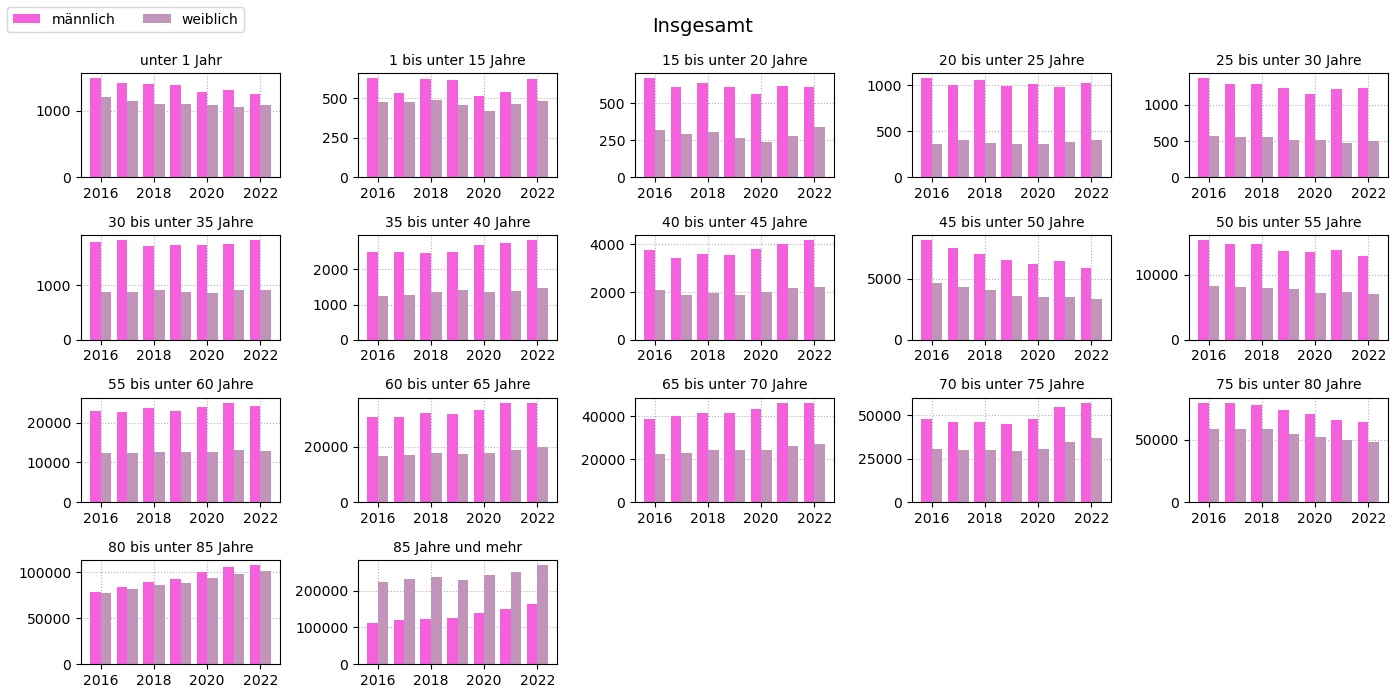

In [4]:
plt.rcParams.update({"axes.titlesize": 10,
                     "figure.titlesize": 14})
colors_m = sns.color_palette("husl", n_colors=count)
colors_w = sns.color_palette("husl", n_colors=count, desat=0.3)
for cause in range(count):
    cause_title = dfm.index[cause+1]
    df_cause_m = pd.DataFrame(columns=dfm.columns, index=years)
    df_cause_w = pd.DataFrame(columns=dfw.columns, index=years)
    # sammle die Daten über die Jahre für eine spezielle Ursache
    # männlich
    for i, tmp in enumerate(list_dfm):
        df_cause_m.iloc[i] = tmp.iloc[cause]
    # weiblich
    for i, tmp in enumerate(list_dfw):
        df_cause_w.iloc[i] = tmp.iloc[cause]
    # figure style
    fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(14,7))
    # subfigure style
    for j, ax in enumerate(axs.ravel()):
        if j>=len(df_cause_w.columns) or (cause_title == "Plötzlicher Kindstod" and j>1):
            ax.set_visible(False)
            continue
        ax.set_title(df_cause_w.columns[j])
        bar1 = ax.bar(df_cause_m.index.values-0.2, df_cause_m.iloc[:,j].values, color=colors_m[cause], width=0.4)
        bar2 = ax.bar(df_cause_w.index.values+0.2, df_cause_w.iloc[:,j].values, color=colors_w[cause], width=0.4)
        ax.grid(ls=':')
        ax.set_axisbelow(True)
    fig.legend([bar1, bar2], ['männlich', 'weiblich'], loc='upper left', ncol=2)
    fig.suptitle(dfw.index[cause+1])
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

## Altersspezifische Mortalität gemäß Todesursachen (männlich + weiblich)

Die absoluten altersspezifischen Todeszahlen werden mit der Populationsgröße der Altersgruppe ins Verhältnis gesetzt:

$$
\text{Altersspezifische Mortalität} = \frac{\text{Absolute Sterbefälle einer Altersgruppe}}{\text{Populationsgröße dieser Altersgruppe}} \cdot 100\,000
$$

Die Vorbereitungen beinhalten Zusammenfassung der einzelnen Altersgruppen. Die Bevölkerungszahlen entstammen dem [Statistischen Bundesamt](https://www.destatis.de/EN/Themes/Society-Environment/Population/Current-Population/Tables/population-by-age-groups.html).

In [5]:
# map for df_deaths
groups_map_deaths = {"unter 40": ["unter 1 Jahr", "1 bis unter 15 Jahre", "15 bis unter 20 Jahre", "20 bis unter 25 Jahre", "25 bis unter 30 Jahre", "30 bis unter 35 Jahre", "35 bis unter 40 Jahre"],
                     "40 bis 60": ["40 bis unter 45 Jahre", "45 bis unter 50 Jahre", "50 bis unter 55 Jahre", "55 bis unter 60 Jahre"],
                     "60 bis 80": ["60 bis unter 65 Jahre", "65 bis unter 70 Jahre", "70 bis unter 75 Jahre", "75 bis unter 80 Jahre"],
                     "80 und älter": ["80 bis unter 85 Jahre", "85 Jahre und mehr"]
                    }
# map for df_pop
groups_map_pop = {"unter 40": ["under 20", "20 to 40"],
                  "40 bis 60": ["40 to 60"],
                  "60 bis 80": ["60 to 80"],
                  "80 und älter": ["80 to 100", "100 and more"]
                 }

In [6]:
# download only if file does not exist locally
def get_file(url, fname):
    if os.path.exists(fname):
        print(f"FOUND: {fname}")
    else:
        urllib.request.urlretrieve(url, fname)
        print(f"DOWNLOADED: {fname}")

# population data
get_file("https://www.destatis.de/EN/Themes/Society-Environment/Population/Current-Population/Tables/population-by-age-groups.html",
         "population-by-age-groups.html")

DOWNLOADED: population-by-age-groups.html


In [7]:
# read HTML table(s) as dataframes
df_pop = pd.read_html(
    "population-by-age-groups.html",
    thousands=',',  # read numbers like "1,000" as "1000"
    index_col=(0),  # first data column is our index column
    skiprows=0
)
df_pop = df_pop[0]  # [0]: gives us the dataframe of the first HTML table
df_pop = df_pop.iloc[:-1,]  # drop last row (we dont need that footer text)
# clean years 2016 and 2017 which have a footnoote mark
df_pop.rename(index={"20171": "2017", 
                     "20161": "2016"},
              inplace=True)
# drop redundant multi-level columns
df_pop = df_pop.droplevel(level=0, axis=1)
# years in ascending order
df_pop = df_pop.sort_index()
# fix datatypes
df_pop = df_pop.astype("int64")
df_pop.index = df_pop.index.astype("int64")
df_pop_final = pd.DataFrame(index=df_pop.index, columns=groups_map_pop.keys())
for key, val in groups_map_pop.items():
    df_pop_final[key] = df_pop[val].sum(axis=1)

df_pop_final.tail()

,unter 40,40 bis 60,60 bis 80,80 und älter
2018,35741344,23900423,17988340,5389106
2019,35798334,23629924,18057318,5681135
2020,35689968,23375290,18153339,5936434
2021,35737969,23068612,18318888,6111655
2022,36497561,22999053,18749279,6112952


## Plot: Altersspezifische Mortalität gemäß Todesursachen (männlich + weiblich)

Zu Erinnerung: Die absoluten altersspezifischen Todeszahlen werden mit der Populationsgröße der Altersgruppe ins Verhältnis gesetzt:

$$
\text{Altersspezifische Mortalität} = \frac{\text{Absolute Sterbefälle einer Altersgruppe}}{\text{Populationsgröße dieser Altersgruppe}} \cdot 100\,000
$$

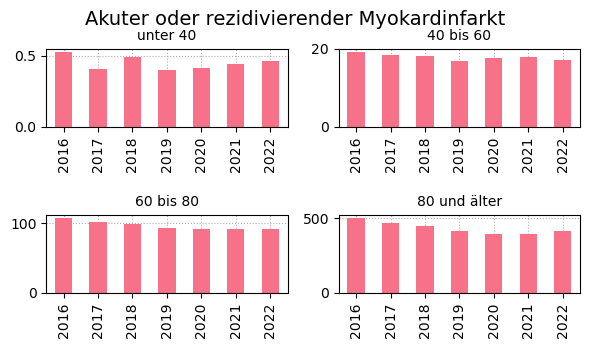

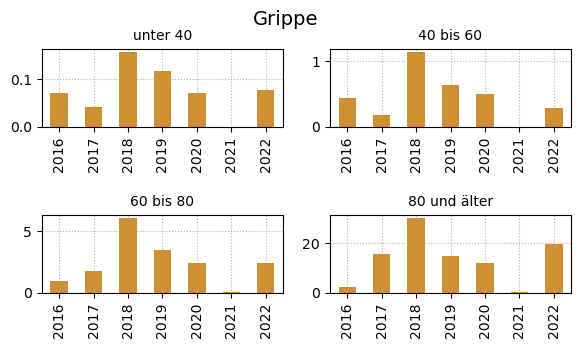

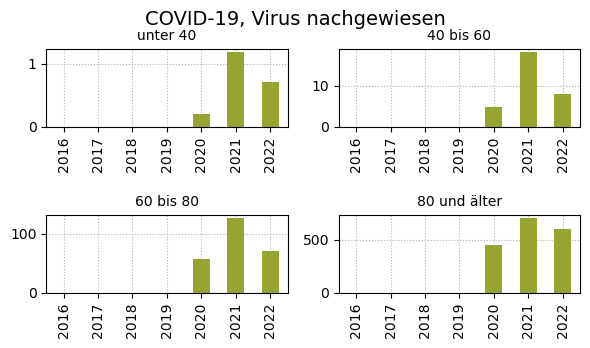

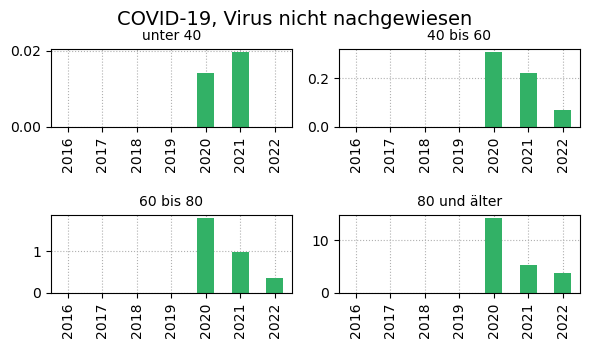

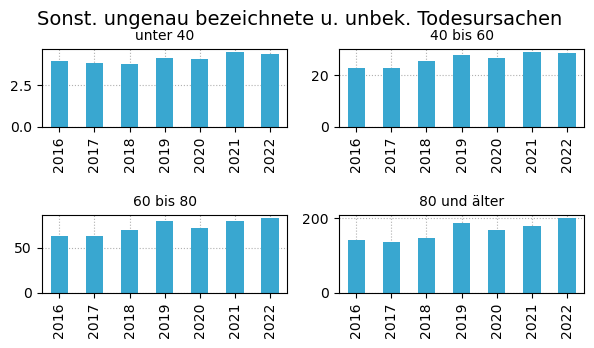

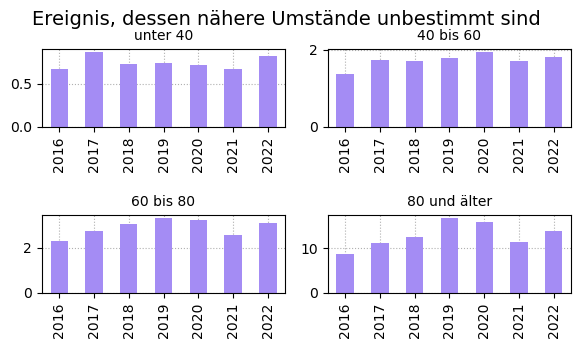

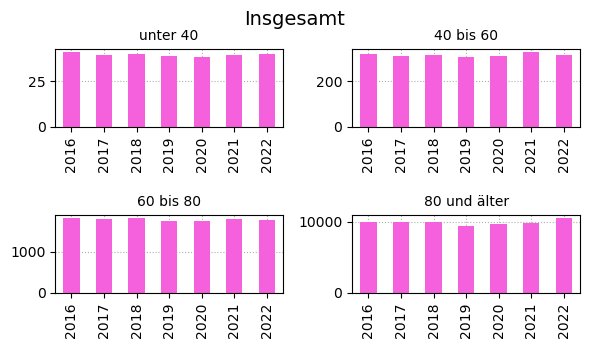

In [8]:
for cause in range(count):
    cause_title = dfm.index[cause+1]
    if cause_title == "Plötzlicher Kindstod":
        continue
    df_sep = pd.DataFrame(columns=dfm.columns, index=years)
    for i, tmp in enumerate(list_dfm):
        df_sep.iloc[i] = tmp.iloc[cause]
    for i, tmp in enumerate(list_dfw):
        df_sep.iloc[i] += tmp.iloc[cause]
    
    df_deaths_final = pd.DataFrame(index=df_sep.index, columns=groups_map_deaths.keys())
    for key, val in groups_map_deaths.items():
        df_deaths_final[key] = df_sep[val].sum(axis=1)
    df_mortality_rate = df_deaths_final / df_pop_final * 100_000
    df_mortality_rate = df_mortality_rate.dropna()
    axs = df_mortality_rate.plot(kind='bar', subplots=True, legend=False, figsize=(6,3.5), layout=(2,2), title=cause_title, sharex=False, grid=True, color=colors_m[cause])
    for ax in axs.ravel():
        ax.grid(ls=':')
        ax.set_axisbelow(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.87)
    plt.show()

# Plot: Population der Altersgruppen

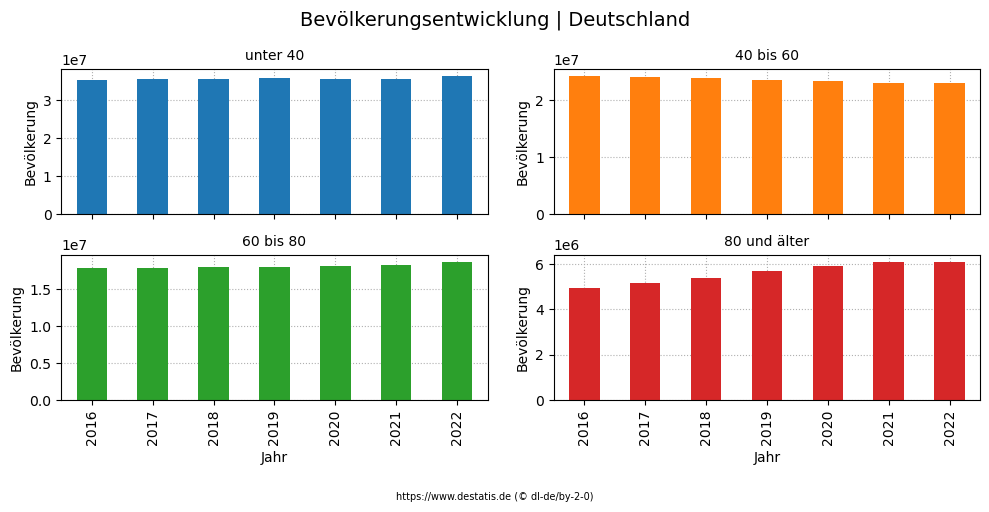

In [9]:
axs = df_pop_final.loc[2016:2022].plot(kind="bar",
    subplots=True, sharex=True, sharey=False, layout=(2,2), figsize=(10,5),
    xlabel="Jahr", ylabel="Bevölkerung", title="Bevölkerungsentwicklung | Deutschland",
    legend=False, grid=True
)

for ax in axs.ravel():
    ax.grid(ls=":")
    ax.set_axisbelow(True)

plt.figtext(0.5, 0.00, "https://www.destatis.de (© dl-de/by-2-0)", horizontalalignment="center", fontsize=7)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

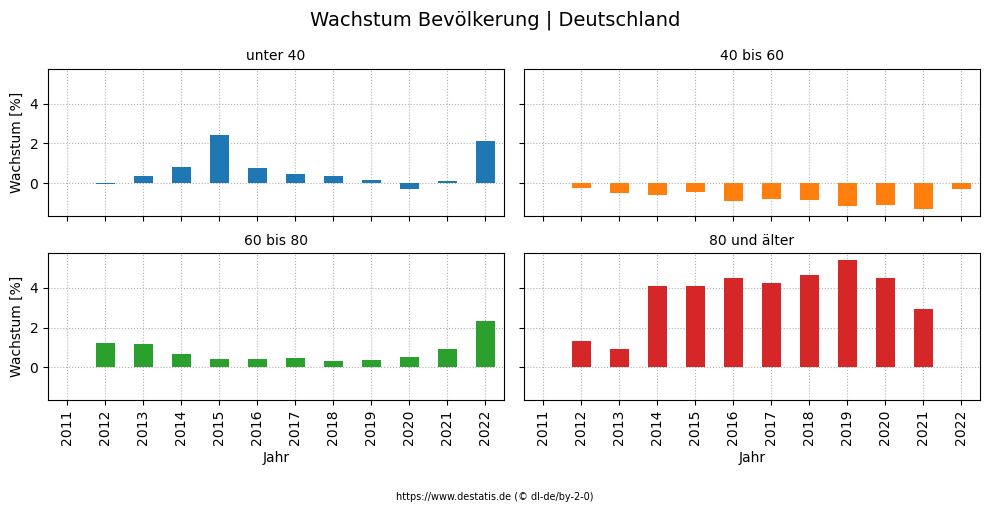

In [10]:
df_pop_change = 100*df_pop_final.pct_change()

axs = df_pop_change.loc[2011:2022].plot(kind="bar",
    subplots=True, sharex=True, sharey=True, layout=(2,2), figsize=(10,5),
    xlabel="Jahr", ylabel="Wachstum [%]", title="Wachstum Bevölkerung | Deutschland",
    legend=False, grid=True
)

for ax in axs.ravel():
    ax.grid(ls=":")
    ax.set_axisbelow(True)

plt.figtext(0.5, 0.00, "https://www.destatis.de (© dl-de/by-2-0)", horizontalalignment="center", fontsize=7)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()